# Model Building

In [1]:
#inport modules
import numpy as np
import pandas as pd
import re
import nltk
import statistics
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
#load preprocessed data
data=pd.read_csv('preprocessed.csv')
data.head(3)

,text,fraudulent
0,market intern we re food and we ve create a gr...,0
1,customer service cloud video production second...,0
2,commission machinery assistant cma valor servi...,0


In [3]:
#X -> data and Y -> target variable
X=data.drop(['fraudulent'],axis=1)
Y=data['fraudulent']

In [4]:
#splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

In [5]:
#using K fold cross validation where number of folds = 5
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=20)

def compare(classifiers):
    i=0
    for train, test in folds.split(X_train, y_train):
        x_train1, x_test1 = X_train['text'][train], X_train['text'][test]
        y_train1, y_test1 = y_train[train], y_train[test]
        
        #Using TF-IDF vectorizer to generate a TF-IDF matrix with ngram range (1,2)
        tfidf = TfidfVectorizer(stop_words="english",ngram_range=(1,2))
        x_train1 = tfidf.fit_transform(x_train1)
        x_test1 = tfidf.transform(x_test1)
        
        #iterating through all the classifiers for ith Kfold 
        for clf in classifiers:
            print(i+1,clf)
            clf.fit(x_train1, y_train1)
            pred = clf.predict(x_test1)
            pred_train = clf.predict(x_train1)
            test_acc[clf].append(accuracy_score(y_test1, pred))
            
            print("Classification report:", clf)
            print(classification_report(y_test1, pred))
            print("Confusion matrix:", clf)
            cm = confusion_matrix(y_test1, pred)
            print(cm)
            spec = cm[1][1]/ (cm[1][1]+cm[0][1])    #calculating specfity as TN/(TN+FP)
            spec_avg[clf].append(spec)
            print()
            print('-'*50)
        i+=1

In [6]:
clf = [KNeighborsClassifier(n_neighbors=10),LogisticRegression(), RandomForestClassifier(), MultinomialNB(alpha=.01)]
#dictionary to store accuracy and specificity for each classifier in every fold
test_acc=dict([(key, []) for key in clf])
spec_avg=dict([(key, []) for key in clf])
compare(clf)

1 KNeighborsClassifier(n_neighbors=10)
Classification report: KNeighborsClassifier(n_neighbors=10)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2724
           1       0.90      0.69      0.78       137

    accuracy                           0.98      2861
   macro avg       0.94      0.84      0.88      2861
weighted avg       0.98      0.98      0.98      2861

Confusion matrix: KNeighborsClassifier(n_neighbors=10)
[[2713   11]
 [  43   94]]

--------------------------------------------------
1 LogisticRegression()
Classification report: LogisticRegression()
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2724
           1       1.00      0.31      0.47       137

    accuracy                           0.97      2861
   macro avg       0.98      0.65      0.73      2861
weighted avg       0.97      0.97      0.96      2861

Confusion matrix: LogisticRegression()
[[2724 

5 KNeighborsClassifier(n_neighbors=10)
Classification report: KNeighborsClassifier(n_neighbors=10)
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2723
           1       0.87      0.69      0.77       137

    accuracy                           0.98      2860
   macro avg       0.93      0.84      0.88      2860
weighted avg       0.98      0.98      0.98      2860

Confusion matrix: KNeighborsClassifier(n_neighbors=10)
[[2709   14]
 [  42   95]]

--------------------------------------------------
5 LogisticRegression()
Classification report: LogisticRegression()
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2723
           1       1.00      0.30      0.46       137

    accuracy                           0.97      2860
   macro avg       0.98      0.65      0.72      2860
weighted avg       0.97      0.97      0.96      2860

Confusion matrix: LogisticRegression()
[[2723 

In [7]:
#converting to percentages
for i in range(0,5):
    for j in range(0,4):
        test_acc[clf[j]][i]*=100
        spec_avg[clf[j]][i]*=100

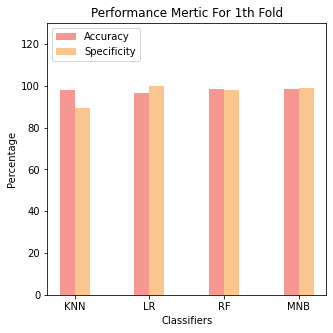

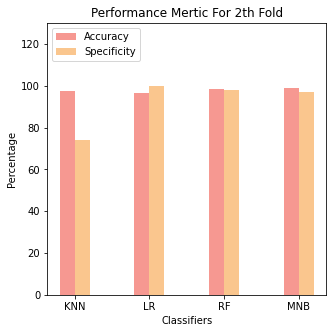

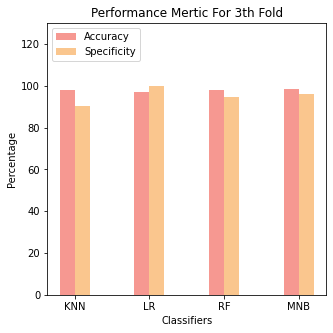

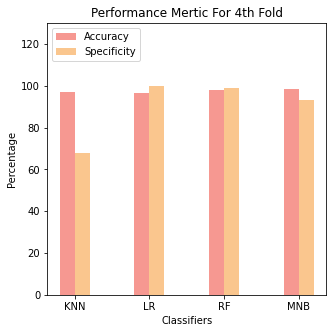

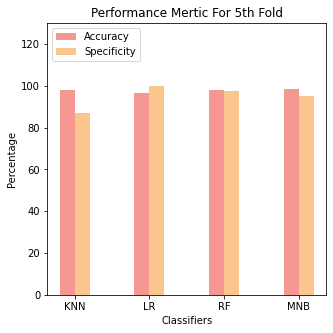

In [8]:
#plotting grouped barchart for every fold
#x axis->classifiers
#y axis->percentage
#plotting accuracy and specificity
for i in range(0,5):
    df=pd.DataFrame([['KNN', test_acc[clf[0]][i], spec_avg[clf[0]][i]],
                     ['LR', test_acc[clf[1]][i], spec_avg[clf[1]][i]],
                     ['RF', test_acc[clf[2]][i], spec_avg[clf[2]][i]],
                     ['MNB', test_acc[clf[3]][i], spec_avg[clf[3]][i]]],columns=['Classifier','Accuracy','Specificity'])

    # Setting the positions and width for the bars
    pos = list(range(len(df['Accuracy'])))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.bar(pos, df['Accuracy'], width, alpha=0.5, color='#EE3224')
    plt.bar([p + width for p in pos], df['Specificity'], width, alpha=0.5, color='#F78F1E')
    
    s='Performance Mertic For ' + str(i+1) + "th Fold"
    ax.set_title(s)
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Classifiers')

    # Setting the position of the x ticks
    ax.set_xticks([p + 0.5 * width for p in pos])
    plt.ylim([0, 130])
    plt.legend(['Accuracy', 'Specificity'], loc='upper left')
    ax.set_xticklabels(df['Classifier'])
    plt.show()

In [9]:
#displays aggregate of accuracy and specificty for each classifier
print("Summary")
for c in clf:
    print('='*50)
    print(c)
    print("Accuracy: ",statistics.mean(test_acc[c]))
    print("specificity: ",statistics.mean(spec_avg[c]))

Summary
KNeighborsClassifier(n_neighbors=10)
Accuracy:  97.66501516658805
specificity:  81.71141130741515
LogisticRegression()
Accuracy:  96.76313480298101
specificity:  100.0
RandomForestClassifier()
Accuracy:  98.20328605333847
specificity:  97.38107783362744
MultinomialNB(alpha=0.01)
Accuracy:  98.5458578471511
specificity:  96.15597147497286


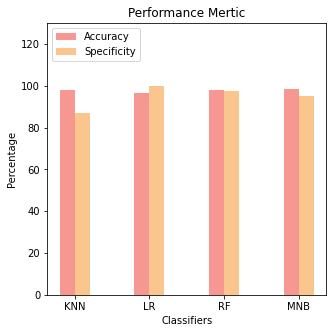

In [10]:
#print(df.head(3))
    # Setting the positions and width for the bars
    pos = list(range(len(df['Accuracy'])))
    width = 0.2
    # Plotting the bars
    fig, ax = plt.subplots(figsize=(5,5))
    plt.bar(pos, df['Accuracy'], width, alpha=0.5, color='#EE3224')
    plt.bar([p + width for p in pos], df['Specificity'], width, alpha=0.5, color='#F78F1E')
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Classifiers')

    # Setting the chart's title
    s='Performance Mertic'
    ax.set_title(s)

    # Setting the position of the x ticks
    ax.set_xticks([p + 0.5 * width for p in pos])
    plt.ylim([0, 130] )
    # Setting the labels for the x ticks
    plt.legend(['Accuracy', 'Specificity'], loc='upper left')
    ax.set_xticklabels(df['Classifier'])
    #df.pivot("Classifier","Accuracy").plot(kind='bar')
    plt.show()